In [1]:
import requests
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Get the data from CryptoAPI

In [2]:
res = requests.get("https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=ILS&apikey=$demo")
data = res.json()
dict_data = data['Time Series (Digital Currency Daily)']

## Working with float as type and Date as type + dropping other columns


In [3]:
features_df = pd.DataFrame.from_dict(dict_data,orient='index')
features_df = features_df[features_df.columns.drop(list(features_df.filter(regex='ILS')))]

features_df.index.name = 'Date'
features_df = features_df.reset_index()
features_df.style.format({"date": lambda t: t.strftime("%d-%m-%Y")}) 
features_df["4b. close (USD)"] = features_df["4b. close (USD)"].astype(float).round(2)
features_df = features_df.rename(columns = {'4b. close (USD)': 'Close'})
features_df =  features_df[::-1].reset_index()
features_df = features_df.drop(columns = ['index','1b. open (USD)', '2b. high (USD)','5. volume','6. market cap (USD)','3b. low (USD)'])

# features_df = features_df.drop(features_df.index[300:1000])


In [4]:
features_df.head()

,Date,Close
0,2018-09-30,6626.57
1,2018-10-01,6611.61
2,2018-10-02,6525.79
3,2018-10-03,6510.00
4,2018-10-04,6593.79


In [5]:
features_df.tail()

,Date,Close
995,2021-06-21,31608.93
996,2021-06-22,32509.56
997,2021-06-23,33678.07
998,2021-06-24,34663.09
999,2021-06-25,34499.95


# Lets look on the past 100 days

### Trading days

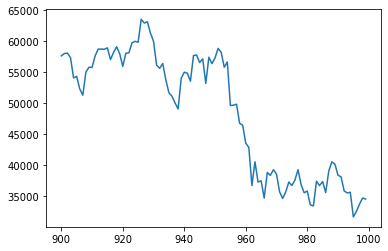

In [6]:

features_df.head()
plt.plot(features_df.tail(100)['Close'])
plt.show()

## Predict n days into the future

In [7]:
future_days = 30

## Create new column (target) shifted n days

In [8]:
features_df['Prediction'] = features_df[['Close']].shift(-future_days)
features_df.head(32)

,Date,Close,Prediction
0,2018-09-30,6626.57,6330.87
1,2018-10-01,6611.61,6371.93
2,2018-10-02,6525.79,6410.00
3,2018-10-03,6510.00,6433.98
4,2018-10-04,6593.79,6387.09
5,2018-10-05,6635.65,6485.85
6,2018-10-06,6594.27,6468.99
7,2018-10-07,6615.26,6519.11
8,2018-10-08,6673.01,6578.46
9,2018-10-09,6656.61,6479.84


In [9]:
features_df.tail()

,Date,Close,Prediction
995,2021-06-21,31608.93,NaN
996,2021-06-22,32509.56,NaN
997,2021-06-23,33678.07,NaN
998,2021-06-24,34663.09,NaN
999,2021-06-25,34499.95,NaN


## Let's split the data to X & y

In [10]:
X = np.array(features_df.drop(['Prediction','Date'],1))[:-future_days]


In [11]:
y = np.array(features_df['Prediction'])[:-future_days]


In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## Let's create our models

In [13]:
models = {"LinearRegression": LinearRegression(), "DecisionTreeRegressor": DecisionTreeRegressor()}

def model_iteration(models, X_train,X_test,y_train,y_test):
    np.random.seed(42)
    model_scores = {}
    for model,model_exec in models.items():
        model_exec.fit(X_train,y_train)
        model_scores[model] = model_exec.score(X_test,y_test)
    return model_scores



In [14]:
model_score = model_iteration(models,X_train,X_test,y_train,y_test)
model_score



{'LinearRegression': 0.884622916665121,
 'DecisionTreeRegressor': 0.9036514811823595}

(array([0, 1]),
 [Text(0, 0, 'LinearRegression'), Text(1, 0, 'DecisionTreeRegressor')])

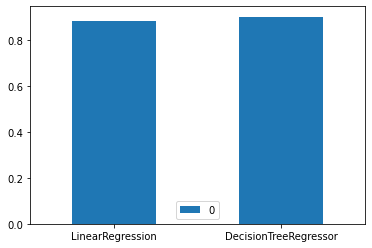

In [15]:
model_score_df = pd.DataFrame.from_dict(model_score,orient='index')
model_score_df.plot.bar()
plt.xticks(rotation=0)

## Create the prediction rows and compare by model

In [16]:
x_future = features_df.drop(['Prediction','Date'],1)[:-future_days]
x_future = x_future.tail(future_days)
x_future
x_future = np.array(x_future)


# Predction Function

In [17]:
def predict_by_model(model,X_train,y_train,x_future):
    np.random.seed(42)
    models = {"LinearRegression": LinearRegression(), "DecisionTreeRegressor": DecisionTreeRegressor()}
    valid = features_df[X.shape[0]:]
    models[model].fit(X_train,y_train)
    predictions = models[model].predict(x_future)
    valid['Prediction'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Days')
    plt.ylabel('Close price USD')
    plt.plot(features_df['Close'])
    plt.plot(valid[['Close','Prediction']])
    plt.legend(['Past','Original Value','Prediction'])
    plt.show()


# LinearRegression

<ipython-input-17-372b2659a524>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = predictions


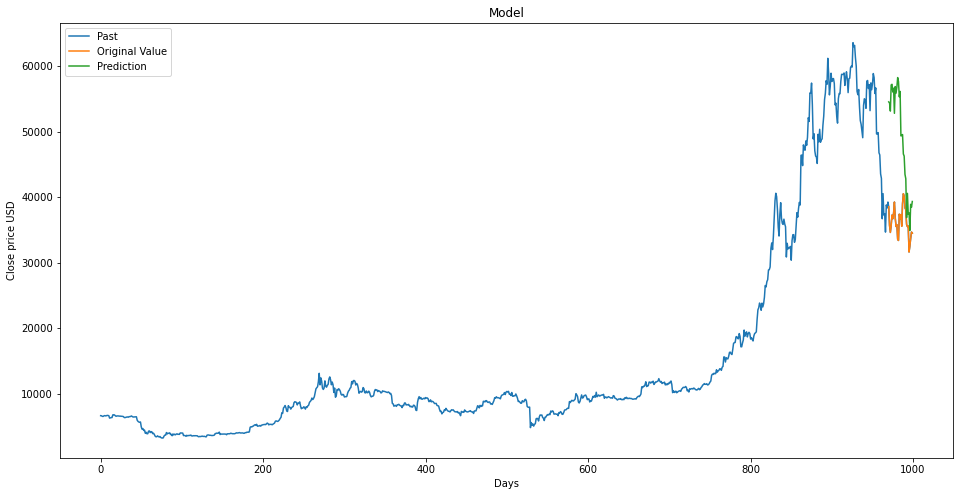

In [18]:
predict_by_model('LinearRegression',X_train,y_train,x_future)

# Let's try to do the same with DecisionTreeRegressor

<ipython-input-17-372b2659a524>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = predictions


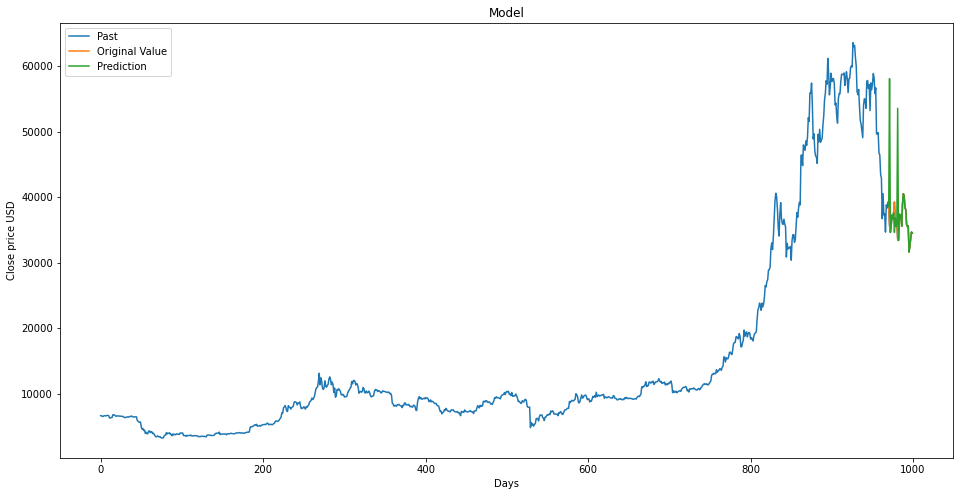

In [19]:
predict_by_model('DecisionTreeRegressor',X_train,y_train,x_future)

## Now we will cut the last n days to predict the next n

In [20]:
x_future_prediction = features_df.drop(['Prediction','Date'],1)[future_days:]
x_future_prediction = x_future_prediction.tail(future_days)
x_future_prediction = np.array(x_future_prediction)
x_future_prediction

array([[38529.98],
       [35663.49],
       [34605.15],
       [35641.27],
       [37253.81],
       [36693.09],
       [37568.68],
       [39246.79],
       [36829.  ],
       [35513.2 ],
       [35796.31],
       [33552.79],
       [33380.81],
       [37388.05],
       [36675.72],
       [37331.98],
       [35546.11],
       [39020.57],
       [40516.29],
       [40144.04],
       [38349.01],
       [38092.97],
       [35819.84],
       [35483.72],
       [35600.16],
       [31608.93],
       [32509.56],
       [33678.07],
       [34663.09],
       [34499.95]])

## Let's use the DecisionTree model for our prediction

In [36]:
tree = DecisionTreeRegressor()
tree.fit(X_train,y_train)
prediction = tree.predict(x_future_prediction)
prediction

array([34663.09, 49133.45, 32509.56, 55906.  , 35600.16, 35819.84,
       48751.71, 34499.95, 38290.24, 55906.  , 49133.45, 50349.37,
       50349.37, 47287.6 , 35819.84, 47287.6 , 55906.  , 47153.69,
       35483.72, 46374.87, 34663.09, 50971.75, 49133.45, 55906.  ,
       55906.  , 37618.87, 47073.73, 50349.37, 32509.56, 32509.56])

In [37]:

new_df = features_df[X.shape[0]:]
date = features_df['Date'][features_df.index[-1]]

new_df = pd.DatetimeIndex(new_df['Date']) + pd.DateOffset(30)
new_df = pd.DataFrame(new_df)
new_df['Prediction'] = prediction

new_df


,Date,Prediction
0,2021-06-26,34663.09
1,2021-06-27,49133.45
2,2021-06-28,32509.56
3,2021-06-29,55906.00
4,2021-06-30,35600.16
5,2021-07-01,35819.84
6,2021-07-02,48751.71
7,2021-07-03,34499.95
8,2021-07-04,38290.24
9,2021-07-05,55906.00


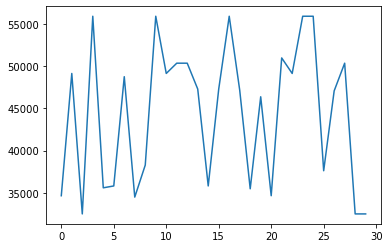

In [38]:
plt.plot(new_df['Prediction'])
plt.show()